# Preprocessing

## 1) Genre and Themes Encoding

### 1.1) Removing Columns

While we kept the numVotes column in the dataset for the EDA, we will remove it now. Similar to end year, the number of votes the movie receives continues to increase sizably after the end date of the movie showing. This would be trying to predict the past from the future and would not help our client in predicting the future from the past.


The storylines column unfortunately contained almost only reviews in place of the storyline. This was caused by a scraping issue we had which we initially thought was only the first half of each entry (first review then storyline) but it was that case that for almost all of the entries. At first, we thought perhaps there could be a way we could still include the reviews as an input for our model, but we soon realized that getting 1 review for each movie would be introducing noise. Moreover, many of the reviews have nothing to do with the actual content (storyline) of the movie but rather the actors, which our model is already using. Hence, we decided it was best to remove the storyline (i.e. the review) column.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bertopic import BERTopic
import random
from sklearn.preprocessing import MultiLabelBinarizer
from factor_analyzer.rotator import Rotator
from collections import Counter
import itertools
import ast

/home/pluseal/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
movie_dataset = pd.read_csv("datasets/7500_movies_dataset.csv")

#Remove numVotes and storyline column
movie_dataset = movie_dataset.drop(['storyline', 'numVotes', 'Unnamed: 0'], axis=1)

<hr style="height:2px;border-width:0;color:red;background-color:red">

### 1.2) Encoding Themes

Because we had highly specific and unique themes (essentially as many of each as there are movies), using standard binary encoding wasn't possible. We still wanted to use them as an input as we imagined they would be valuable to determining a movie's success. So, we decided to use sentiment and topic analysis. 

Before we get into the categorizing of themes, lets first view some instances of them:

In [3]:
for row in movie_dataset['themes'].head(5):
    print(f"Themes: {row} ({type(row)})")
    print('-' * 60)

Themes: ['based on video game', 'gore', 'mortal kombat', 'reboot', 'two word title'] (<class 'str'>)
------------------------------------------------------------
Themes: ['assassin', 'hitman', 'gun', 'weapon', 'gun fight'] (<class 'str'>)
------------------------------------------------------------
Themes: ['barry allen character', 'the flash character', 'dc extended universe', 'multiverse', 'struck by lightning'] (<class 'str'>)
------------------------------------------------------------
Themes: ['witch', 'based on novel', 'coven', 'witchcraft', 'taking off shoes'] (<class 'str'>)
------------------------------------------------------------
Themes: ['jungle', 'boat', 'amazon river', 'riverboat', 'gay brother'] (<class 'str'>)
------------------------------------------------------------


**1.2.1) Sentiment Analysis**

Now, to use the themes column, we have to turn it into categories. We have decided to use the sentiments and topics that can be extracted from this column. First, lets create some functions to better preprocess the themes and classify the sentiment:

In [4]:
def clean_themes(x):
    """
    Turn themes into strings if they are a list or if they are a list inside a string (as is the case in our data).
    """
    if isinstance(x, list):
        return ' '.join(x).strip()
    try:
        parsed = eval(x)
        if isinstance(parsed, list):
            return ' '.join(parsed).strip()
    except Exception:
        pass
    return ''


def equate_empty_themes(x):
    """
    Ensure empty entries are of the same type to avoid future problems in topic extraction.
    """
    # empty-looking strings
    if isinstance(x, str) and x.strip() in ['', '[, , ]', '[, , ,]', '[ , , ]']:
        return ''
    # string that looks like a Python list
    try:
        parsed = eval(x)
        if isinstance(parsed, list) and all(not str(w).strip() for w in parsed):
            return ''
    except Exception:
        pass
    return x


def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

Next we'll employ BERT and vaderSentiment, two common tools to extract sentences and topics from natural language texts. First lets view some examples of themes:

In [5]:
# Turn strings in the form of python lists to actual lists
movie_dataset['themes'] = movie_dataset['themes'].fillna('').astype(str).apply(clean_themes)

print("Some examples of topic sentiments:\n")
for i, val in enumerate(movie_dataset['themes'].head(5), 1):
    print(f"{i}: {val}")

Some examples of topic sentiments:

1: based on video game gore mortal kombat reboot two word title
2: assassin hitman gun weapon gun fight
3: barry allen character the flash character dc extended universe multiverse struck by lightning
4: witch based on novel coven witchcraft taking off shoes
5: jungle boat amazon river riverboat gay brother


Now we can apply sentiment analysis on these themes:

In [6]:
analyzer = SentimentIntensityAnalyzer()
movie_dataset['theme_sentiment'] = movie_dataset['themes'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

movie_dataset['theme_sentiment_label'] = movie_dataset['theme_sentiment'].apply(classify_sentiment)

# Show frequencies
print(movie_dataset['theme_sentiment_label'].value_counts())

theme_sentiment_label
neutral     4293
negative    1877
positive    1399
Name: count, dtype: int64


Lets view some examples of themes classified as each sentiment:

In [7]:
for label in ['positive', 'negative', 'neutral']:
    print(f"\n--- 5 random themes classified as {label} ---")
    sample = movie_dataset[movie_dataset['theme_sentiment_label'] == label]['themes'].sample(5, random_state=42)
    for theme in sample:
        print(f"[{theme}]")


--- 5 random themes classified as positive ---
[daughter prince love husband wife relationship period piece]
[love]
[female frontal nudity female nudity escape psychological thriller female rear nudity]
[love family relationships fight brawl one person army action]
[scientist couple love]

--- 5 random themes classified as negative ---
[limited dialogue apocalyptic cult ancient evil devil baby human sacrifice]
[folk horror supernatural horror]
[cat ghost cat co production based on manga anime animation]
[greed advocate lawyer dark comedy]
[tambura band anger]

--- 5 random themes classified as neutral ---
[soldier]
[]
[]
[pregnancy pet cat old house country side husband wife relationship]
[]


**1.2.2) Sentiment of Movie Titles**

Next lets extract the sentiments from the movie titles:

In [8]:
#Do the same for primary titles
movie_dataset['primaryTitle'] = movie_dataset['primaryTitle'].fillna('').astype(str).str.strip()

#Apply vader sentiment analysis
movie_dataset['title_sentiment'] = movie_dataset['primaryTitle'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

#Classify for Interpretability
movie_dataset['title_sentiment_label'] = movie_dataset['title_sentiment'].apply(classify_sentiment)

#Print first 10 for checks of accuracy and type
for i, val in enumerate(movie_dataset['primaryTitle'].head(10), 1):
    print(f"{i}: {val}  |  sentiment: {movie_dataset['title_sentiment_label'].iloc[i]}")

1: Mortal Kombat  |  sentiment: neutral
2: The Killer's Game  |  sentiment: neutral
3: The Flash  |  sentiment: neutral
4: The Witches  |  sentiment: neutral
5: Jungle Cruise  |  sentiment: neutral
6: Hellraiser  |  sentiment: neutral
7: The Amateur  |  sentiment: positive
8: Lost Girls and Love Hotels  |  sentiment: neutral
9: Fantasy Island  |  sentiment: neutral
10: A Journal for Jordan  |  sentiment: neutral


As we can see above, the sentiment analysis is inconsequential and inaccurate for titles. This is likely because they are very short and uninformative blank statements that usually contain very implicit information about the movie. 

For this reason, we would like to remove this column without losing all information within the title. Since we are already extracting contents from a combination of genres and themes, which are longer, more extensive and accurate, we decided it would be best to remove the primary title in its entirety.

In [9]:
movie_dataset.drop(columns=['primaryTitle', 'title_sentiment', 'title_sentiment_label'], inplace=True)

**1.2.3) Theme Topic Clustering**

Next lets extract the topic clusters:

In [10]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(movie_dataset['themes'])

# Number of topics (excluding outliers labeled -1)
n_topics = len(set([t for t in topics]))
n_meaningful_topics = len(set([t for t in topics if t != -1]))
print(f"Number of total topic clusters found: {n_topics}\n")
print(f"Number of meaningfultopic clusters found: {n_meaningful_topics}\n")

topic_info = topic_model.get_topic_info()
print("Example of a topic: \n", topic_info.iloc[0])

#Turn numeric outputs of BERT to cluster descriptors in natural language for interpretability
topic_map = dict(zip(topic_info['Topic'], topic_info['Name']))
movie_dataset['theme_topic'] = topics
movie_dataset['theme_topic_label'] = movie_dataset['theme_topic'].map(topic_map)

Number of total topic clusters found: 139

Number of meaningfultopic clusters found: 138

Example of a topic: 
 Topic                                                                 -1
Count                                                               1913
Name                                   -1_relationship_female_nudity_son
Representation         [relationship, female, nudity, son, boy, fathe...
Representative_Docs    [woman father male nudity father son relations...
Name: 0, dtype: object




Lets view some examples of movies placed within these topic clusters:

In [11]:
random_ids = random.sample(list(topic_info['Topic']), 3)
for cid in random_ids:
    print(f"\n--- First 10 themes in cluster {cid} ---")
    print(movie_dataset[movie_dataset['theme_topic'] == cid]['themes'].head(5).to_list())


--- First 10 themes in cluster 78 ---
['art robbery heist police officer storm', 'bank robbery bank heist acassusso buenos aires argentina buenos aires argentina based on real person', 'thief poker game panic room directed by star gambler', 'bank robbery london gang', 'bank heist epic action heist crime']

--- First 10 themes in cluster 45 ---
['male frontal nudity female full frontal nudity male full frontal nudity male pubic hair standing doggystyle vaginal sex', 'fear student fraternity hairy armpits fat boy', 'male pubic hair teenage boy full frontal nudity touching penis male full frontal nudity male nudity', 'male full frontal nudity male frontal nudity male pubic hair pubic hair male nudity', 'male nudity male full frontal nudity male frontal nudity pubic hair male pubic hair']

--- First 10 themes in cluster 22 ---
['survival ocean norway icy waters scuba diving', 'ocean diving swimming reference to jacques cousteau exploration', 'jungle jungle adventure', 'beach diving drowni

<hr style="height:2px;border-width:0;color:red;background-color:red">

### 1.3) Encoding Genres Using PCA

We decided to use multiple hot encoding for genres because they aren't sentences written in natural language, but rather combinations of fixed terms such as "horror" and "drama". We also observed that some genres co-occurred more frequently than others, indicating the presence of covariances between them. 

To capture these dependencies and reduce dimensionality, we applied Principal Component Analysis (PCA). Specifically, we constructed a covariance matrix over the binary genre indicators and computed its eigenvectors and eigenvalues. We then selected the eigenvectors corresponding to the largest eigenvalues, those capturing the directions of highest variance in the genre space. This transformation allowed us to retain most of the genre-related information, reduce computational complexity, and lower the risk of overfitting. 

In [12]:
movie_dataset['genres'] = movie_dataset['genres'].fillna('').apply(lambda x: [g for g in x.split(',')])
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movie_dataset['genres'])

# Initial PCA to examine variances captured by each PC.
pca_temp = PCA()
pca_temp.fit(genre_encoded)

# Apply PCA with selected number of components
pca_genres = PCA(n_components=0.99)

**1.3.1) Elbow Point**

Let's see if graphing the number of principal components against the cumulative explained variance showcases an elbow point i.e. a radical change in variance explained per added PC:

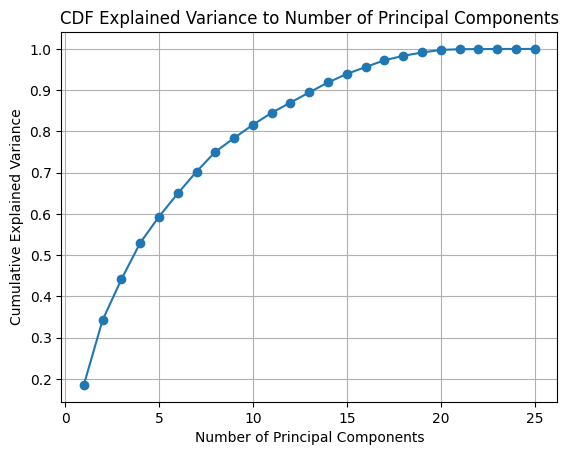

In [13]:
# Cumulative explained variance
cumulative_variance = np.cumsum(pca_temp.explained_variance_ratio_)

# Plot
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('CDF Explained Variance to Number of Principal Components')
plt.grid(True)
plt.show()

Although we don't see a perfect elbow point, we do see that explained variance per PC decreases sizably throughout the graph. We decided to put a cutoff point of 4% (1/25) because we originally had 25 genres and didn't want to include a variance direction that would be contributing less than an individual genre if all were uncorrelated and had equal variances. This heuristic would suggest that we use 8 components, all of which explain more than 1/25 or 4% of the variance. 

However, we also wanted to check where the slope change of the graph dropped below 0.5% from Principal Component to Principal Component to apply a heuristic based quasi elbow method. In the elbow method we landed on 6 PCs which wasn't far from 8 our initial heuristic found. But 6 components would explain less than 70% of the variance, which is a common threshhold for Principal Component Analysis. Hence, we decided to keep 8 components, explaining approximately 74% of the total variance, which is again around the common threshhold of 70-80%. We thought this would capture the important patterns in the data and would be less prone to noise.

In [14]:
expl_var_ratio = pca_temp.explained_variance_ratio_
diffs = np.diff(expl_var_ratio)
elbow_index = np.argmax(abs(diffs) < 0.005) + 1  
print(f"Elbow heuristic suggests: {elbow_index} components")

# Select components that explain at least 4% of the variance
selected_components = np.where(expl_var_ratio >= 0.04)[0]
n_components = len(selected_components)

print(f"Selected {n_components} components (≥ 4% variance each): {selected_components + 1}")

total_explained = np.sum(pca_temp.explained_variance_ratio_[selected_components])
print(f"Total explained variance by first 8 PCs: {total_explained:.4f} ({total_explained * 100:.2f}%)")

Elbow heuristic suggests: 6 components
Selected 8 components (≥ 4% variance each): [1 2 3 4 5 6 7 8]
Total explained variance by first 8 PCs: 0.7507 (75.07%)


<hr style="height:2px;border-width:0;color:red;background-color:red">

### 1.4) Genres Varimax Rotation

After the dimension reduction we applied to genres, we wanted to understand the meanings of the new reduced dimensions. To do so, we applied the varimax orthogonal rotation through which the principal components are rotated (as a whole keeping orthogonality) to make the factor loadings in each PC approach 0 or 1. This way, each rotated PC becomes interpretable and we understand the remaining Principal Components. 

In [15]:
rotator = Rotator()

# Apply Varimax rotation
rotated_genres = rotator.fit_transform(pca_temp.components_[:8].T)

# Get genre feature names
genre_names = list(mlb.classes_)  # array of genre strings, in same order as MultiLabelBinarizer

# For each PC, show top 3 contributing genres by absolute loading
for i in range(rotated_genres.shape[1]):  # iterate over PCs
    print(f"\nPC {i+1} - Top 3 genres:")
    pc_loadings = pd.Series(rotated_genres[:, i], index=genre_names)
    print(pc_loadings.abs().sort_values(ascending=False).head(3))


PC 1 - Top 3 genres:
Drama          0.947954
Documentary    0.272589
Horror         0.098876
dtype: float64

PC 2 - Top 3 genres:
Comedy     0.920167
Crime      0.241782
Mystery    0.173579
dtype: float64

PC 3 - Top 3 genres:
Action     0.933287
Horror     0.201739
Mystery    0.184483
dtype: float64

PC 4 - Top 3 genres:
Documentary    0.459190
Biography      0.384261
Horror         0.360886
dtype: float64

PC 5 - Top 3 genres:
Adventure    0.697614
Animation    0.404209
Family       0.392592
dtype: float64

PC 6 - Top 3 genres:
Romance    0.868808
Horror     0.385881
Mystery    0.194584
dtype: float64

PC 7 - Top 3 genres:
Thriller    0.933262
Horror      0.217867
Crime       0.175184
dtype: float64

PC 8 - Top 3 genres:
Crime     0.803869
Horror    0.515148
Action    0.126398
dtype: float64


Lets also view the genre frequencies:

In [16]:
#Add the rotated pc scores to as a column
pc_scores = genre_encoded @ rotated_genres
movie_dataset['genre_pc'] = list(pc_scores)

# Flatten the genre lists and count occurrences
genre_counts = Counter(itertools.chain.from_iterable(movie_dataset['genres']))

# Convert to DataFrame for easier viewing
genre_freq = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count'])
genre_freq = genre_freq.sort_values(by='count', ascending=True)

print(genre_freq.head(10)) 
print(genre_freq.tail(10))

           count
Talk-Show      1
Adult          1
News           2
\N             5
Western       20
Musical       77
War          105
Sport        139
Sci-Fi       232
Music        238
             count
Documentary    518
Mystery        527
Adventure      730
Crime          756
Romance        786
Horror         867
Thriller      1169
Action        1234
Comedy        2527
Drama         3946


Because LightGBM can take categorical features but only when they are strings or values and not lists, we have to use the multi hot encoding of genres and add 25 more columns to the movie_dataset. This way, LightGBM will simply find the ideal splits in each category of genres (1 or 0) maximizing gain updates per split (how much polarization increases per split). 

Hence, this is the most optimal way to feed genres without sacrificing any information and handling genres which is a list of categories per movie appropriately. NOTE: We will still use the principal components we extracted from the 25 genres and compare the results. 

It could be that the principal components may lead to less overfitting than feeding all 25 genres, since the ladder includes more error and noise. Still, our research indicated that as a default it is optimal to use the categorical_feature method of LightGBM for a feature as genres. Similarly for topics and sentiments of themes but of course extraction of these two new categories is a necessity to feed them to Light GBM.

In [17]:
#Convert Genres into categorical columns that lightgbm can use
genre_encoded = mlb.fit_transform(movie_dataset['genres'])
genre_columns = pd.DataFrame(genre_encoded, columns=mlb.classes_)
genre_columns.index = movie_dataset.index
movie_dataset = pd.concat([movie_dataset, genre_columns], axis=1)

print(movie_dataset.columns)

Index(['averageRating', 'isAdult', 'startYear', 'runtimeMinutes', 'genres',
       'themes', 'director', 'actors', 'grossWorldwide', 'movieType1M',
       'movieType100M', 'theme_sentiment', 'theme_sentiment_label',
       'theme_topic', 'theme_topic_label', 'genre_pc', 'Action', 'Adult',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Talk-Show',
       'Thriller', 'War', 'Western', '\N'],
      dtype='object')


<hr style="height:2px;border-width:0;color:red;background-color:red">

## 2) Director and Actor Encoding

Both the directors and actors column have a high cardinality. This distribution is quite tricky to work with, as this leads to many categories if using conventional methods, which can lead to overfitting and high training time.

So, we'll try two different methods for encoding these columns:
1. **Frequency Encoding**. This involves replacing the original columns with new columns which have the frequency the directors and actors appear in the dataset. The reasoning for this is that directors and actors who continue to make high-quality and well-performing movies will continue to get funded, leading to them making more movies. This means that frequency encoding could be a good distinguishing feature for what makes a movie a blockbuster.
2. **Target Encoding**. At first, we considered creating a heuristic metric that combines both gross worldwide income and average IMDB rating, but after some deliberation we decided to create two new columns, one for the average gross worldwide income, and one for the average averageRating, as this will lead better interpretability. In order to not predict the past from the future, we need to first split the data chronologically into training and testing datasets, measure the values for each director on the training dataset, and only then apply it to the testing dataset.

Since the process of encoding for the directors and actors is extremely similar, with only minor changes, we decided to make functions to avoid code repitition and create a good flow in the notebook. Lets import the functions from an external "director_actor_encoding.py" file contained in the "aux_files" folder of the repository in order to perform the encoding.

In [18]:
import sys
sys.path.append("aux_files")

In [19]:
from director_actor_encoding import data_explore, remove_non_string, group_gw_and_ar, map_groups, map_default_values

In [20]:
movie_dataset = movie_dataset.copy()

<hr style="height:2px;border-width:0;color:red;background-color:red">

### 2.1) Preparing the Data for Actors and Directors

The directors column has high cardinality and low frequency, with 9371 unique values from the 11617 values overall (as seen in the unique values section of eda.ipynb). Before performing the encoding, it is important to first look at the data for any missing values. 

First, lets see if there are any missing values in the directors column.

There are 79 entries whose datatype is a float. These are most likely NaN values, which are treated as floats. Lets check:

In [21]:
print(data_explore(movie_dataset, "director"))

(director
<class 'str'>    7569
Name: count, dtype: int64, Series([], Name: director, dtype: object))


Indeed, lets remove these.

In [22]:
remove_non_string(movie_dataset, "director")
print(len(movie_dataset))

7569


Although the process of encoding the actors appears to be extremely similar to the process of encoding directors, there is one key difference that must be accounted for: there are multiple actors that belong to a single movie, so this must be handled accordingly.

In the exploratory data analysis (EDA), it was revealed that although the actors appear to be stored in a list (since they are in the format ['...'], this is not the case - the actors are stored as a string. Even though this was changed to work as a list in the EDA, the overall dataset was not changed. In this case, it would be useful if the actors are stored as a list since this way we can use the .exploding method to only have one actor per row, and make it easier to encode. So, lets make sure that the actors are indeed stored as a string, and if so, convert them into a list.

In [23]:
# Printing the type of the column to ensure that it is indeed a string that needs converting
print("Type before conversion", type(movie_dataset['actors'].iloc[0]))

# Converting the actors column from strings to lists in both the training and testing set
movie_dataset['actors'] = movie_dataset['actors'].apply(ast.literal_eval)
print("Type after conversion", type(movie_dataset['actors'].iloc[0]))

Type before conversion <class 'str'>
Type after conversion <class 'list'>


Now that we have ensured that the actors column is stored as a list, we need to change the way that the actors are stored per column so that we have only one actor per column.

Lets use the .explode method which, rather than having all the actors in one row, it splits one movie into three rows, each containing an individual actor. Finally, since we will have one actor per row now, lets also change the name of the column "actors" to "actor" for clarity reasons (should be done in the training and testing data set).

In [24]:
# Exploding the training data
movie_dataset = movie_dataset.explode('actors').reset_index(drop=True)
movie_dataset = movie_dataset.rename(columns={'actors': 'actor'})

# Finally, we want to ensure that the exploding has converted the actors back into strings
print(type(movie_dataset['actor'].iloc[0]))

<class 'str'>


In [25]:
print(data_explore(movie_dataset, "actor"))

(actor
<class 'str'>      22397
<class 'float'>       42
Name: count, dtype: int64, 106     NaN
618     NaN
2844    NaN
2959    NaN
3665    NaN
4188    NaN
4745    NaN
4746    NaN
5175    NaN
6281    NaN
Name: actor, dtype: object)


Now, we can do the same for directors where we check for any missing values

In [26]:
remove_non_string(movie_dataset, "actor")
print(len(movie_dataset))

22439


<hr style="height:2px;border-width:0;color:red;background-color:red">

### 2.2) Frequency encoding

Now we can do the frequency encoding for the directors and the directors:

In [27]:
# Director frequency encoding
director_frequencies = movie_dataset["director"].value_counts()
movie_dataset.loc[:, "director_frequencies"] = movie_dataset["director"].map(director_frequencies)
print(movie_dataset[["director", "director_frequencies"]].head(5), "\n")

# -----------------------------------
# Actor frequency encoding
actor_frequencies = movie_dataset["actor"].value_counts()
movie_dataset.loc[:, "actor_frequencies"] = movie_dataset["actor"].map(actor_frequencies)
print(movie_dataset[["actor", "actor_frequencies"]].head(5))

        director  director_frequencies
0  Simon McQuoid                     3
1  Simon McQuoid                     3
2  Simon McQuoid                     3
3     J.J. Perry                     3
      J.J. Perry                     3

              actor  actor_frequencies
0         Lewis Tan                1.0
1   Jessica McNamee                2.0
2       Josh Lawson                2.0
3     Dave Bautista                4.0
4  Dmitrij Kalacsov                1.0


<hr style="height:2px;border-width:0;color:red;background-color:red">

### 2.3) Target encoding

Now we can do our next approach, the target encoding. As mentioned earlier, we must first split the data chronologically into a training and testing dataset:

In [28]:
# Filtering the gross income to above 1M
movie_dataset = movie_dataset[movie_dataset['grossWorldwide'] >= 100000].copy()

train_set = movie_dataset[movie_dataset["startYear"] <= 2023].copy()
test_set = movie_dataset[movie_dataset["startYear"] > 2023].copy()

print(f"Train_set proportion: {len(train_set)/len(movie_dataset):.3f}")
print(f"Test_set proportion: {len(test_set)/len(movie_dataset):.3f}")

Train_set proportion: 0.751
Test_set proportion: 0.249


This is an adequate train/test split. Now we need to find the average grossWordwide and average averageRating for each director and actor. To do this we will use the groupby method:

In [29]:
# Grouping directors
directors_grouped_gw, directors_grouped_ar = group_gw_and_ar(train_set, "director")

print(directors_grouped_gw.head(5), "\n")
print(directors_grouped_ar.head(5), "\n")

# -----------------------------------
# Grouping actors
actor_grouped_gw, actor_grouped_ar = group_gw_and_ar(train_set, "actor")

print(actor_grouped_gw.head(5), "\n")
print(actor_grouped_ar.head(5), "\n")

director
A.L. Vijay         7.917440e+05
A.R. Murugadoss    1.738535e+06
A.V. Rockwell      3.463680e+06
Aanand L. Rai      3.669145e+05
Aaron Horvath      1.360848e+09
Name: grossWorldwide, dtype: float64 

director
A.L. Vijay         5.90
A.R. Murugadoss    5.90
A.V. Rockwell      7.00
Aanand L. Rai      5.95
Aaron Horvath      7.00
Name: averageRating, dtype: float64 

actor
50 Cent          37917985.0
A.J. Lister        138617.0
Aadhi             2796782.0
Aamir Khan       12093536.0
Aaron Bezemer     2244164.0
Name: grossWorldwide, dtype: float64 

actor
50 Cent          4.8
A.J. Lister      6.2
Aadhi            4.8
Aamir Khan       5.6
Aaron Bezemer    4.8
Name: averageRating, dtype: float64 



These two new series can now be used to assign a value to two new columns in train_set and test_set. These columns will be called director_avg_grossWorldwide and director_avg_averageRating. Lets do it for the training dataset first:

In [30]:
# Creating the new columns in training dataset for directors 
train_set["director_avg_grossWorldwide"] = None
train_set["director_avg_averageRating"] = None

# -----------------------------------
# Creating the new columns in training dataset for actors
train_set["actor_avg_grossWorldwide"] = None
train_set["actor_avg_averageRating"] = None

In [31]:
# Mapping the grouped series created earlier that includes the average gross income/rating for each 
# director onto train_set for directors
d_map_gw, d_map_ar = map_groups(train_set, "director", directors_grouped_gw, directors_grouped_ar)

train_set["director_avg_grossWorldwide"] = d_map_gw
train_set["director_avg_averageRating"] = d_map_ar

# -----------------------------------
# Mapping the grouped series created earlier that includes the average gross income/rating for each 
# director onto train_set for actors
a_map_gw, a_map_ar = map_groups(train_set, "actor", actor_grouped_gw, actor_grouped_ar)

train_set["actor_avg_grossWorldwide"] = a_map_gw
train_set["actor_avg_averageRating"] = a_map_ar

Next, we do the same for the testing dataset. Due to the sheer amount of unique values, however, this dataset will include directors that are not in the grouped object i.e. directors who are making their first movie. For directors such as these, we will fill in these values with the average gross income and average rating for all directors that have made only one movie, as taking the global average would be a bit too optimistic in my opinion. 

There is a notable caveat with this approach, however, as it assumes that actors who made movies in the test_set haven't made any movies before the time period of train_set i.e. before 2020. It could be the case that an esteemed director who has made many popular movies in 2010-2015, but who hasn't made any movies between 2020 and 2024, makes a movie in 2025. In this case we will take the default grossWorldwide and default averageRating, which might not be the optimal choice.

In [32]:
# Creating the new columns in the original test dataset for directors
test_set["director_avg_grossWorldwide"] = None
test_set["director_avg_averageRating"] = None

test_d_gw, test_d_ar = map_default_values(train_set, "director", test_set, directors_grouped_gw, directors_grouped_ar)

test_set["director_avg_grossWorldwide"] = test_d_gw
test_set["director_avg_averageRating"] = test_d_ar

# -----------------------------------
# Creating the new columns in the original test dataset for actors
test_set["actor_avg_grossWorldwide"] = None
test_set["actor_avg_averageRating"] = None

test_a_gw, test_a_ar = map_default_values(train_set, "actor", test_set, actor_grouped_gw, actor_grouped_ar)

test_set["actor_avg_grossWorldwide"] = test_a_gw
test_set["actor_avg_averageRating"] = test_a_ar

The default grossWorldwide value for director is: 2543382.0625
The default averageRating value for director is: 7.3
The default grossWorldwide value for actor is: 12229146.569836445
The default averageRating value for actor is: 6.039122883195832


We had a bug with null values in the codeblock above, just checking for them:

In [33]:
print(test_set['director_avg_grossWorldwide'].isna().sum())
print(test_set['director_avg_averageRating'].isna().sum())

0
0


<hr style="height:2px;border-width:0;color:red;background-color:red">

## 3) Saving the Datasets

Now that we've finished the encoding, lets save the altered movie_dataset, the preprocessed train dataset, and preprocessed test dataset to csvs to use in model.ipynb:

In [34]:
movie_dataset.to_csv("datasets/movie_dataset_preprocessed.csv")
train_set.to_csv("datasets/train_preprocessed.csv")
test_set.to_csv("datasets/test_preprocessed.csv")